In [ ]:
#Gerekli kutuphanelerin yuklenmesi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.optimizers import Adam, SGD

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
import cv2

In [ ]:
#Dataseti cekmek icin Drive'a baglanmak gerekiyor
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Labellarin goruntulenmesi
df = pd.read_csv('/content/drive/MyDrive/mL_proje/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
#Resimlerin dosya yollari
img_file='/content/drive/MyDrive/mL_proje/train/'

In [ ]:
#Datasete yeni sutun eklenmesi
df_new = df.assign(img_path=lambda x: img_file + x['id'] +'.jpg')
df_new.head()

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/content/drive/MyDrive/mL_proje/train/000bec18...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/content/drive/MyDrive/mL_proje/train/001513df...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/content/drive/MyDrive/mL_proje/train/001cdf01...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/content/drive/MyDrive/mL_proje/train/00214f31...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/content/drive/MyDrive/mL_proje/train/0021f9ce...


In [ ]:
#Classlarin datasette bulunma sayilari
df_new.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

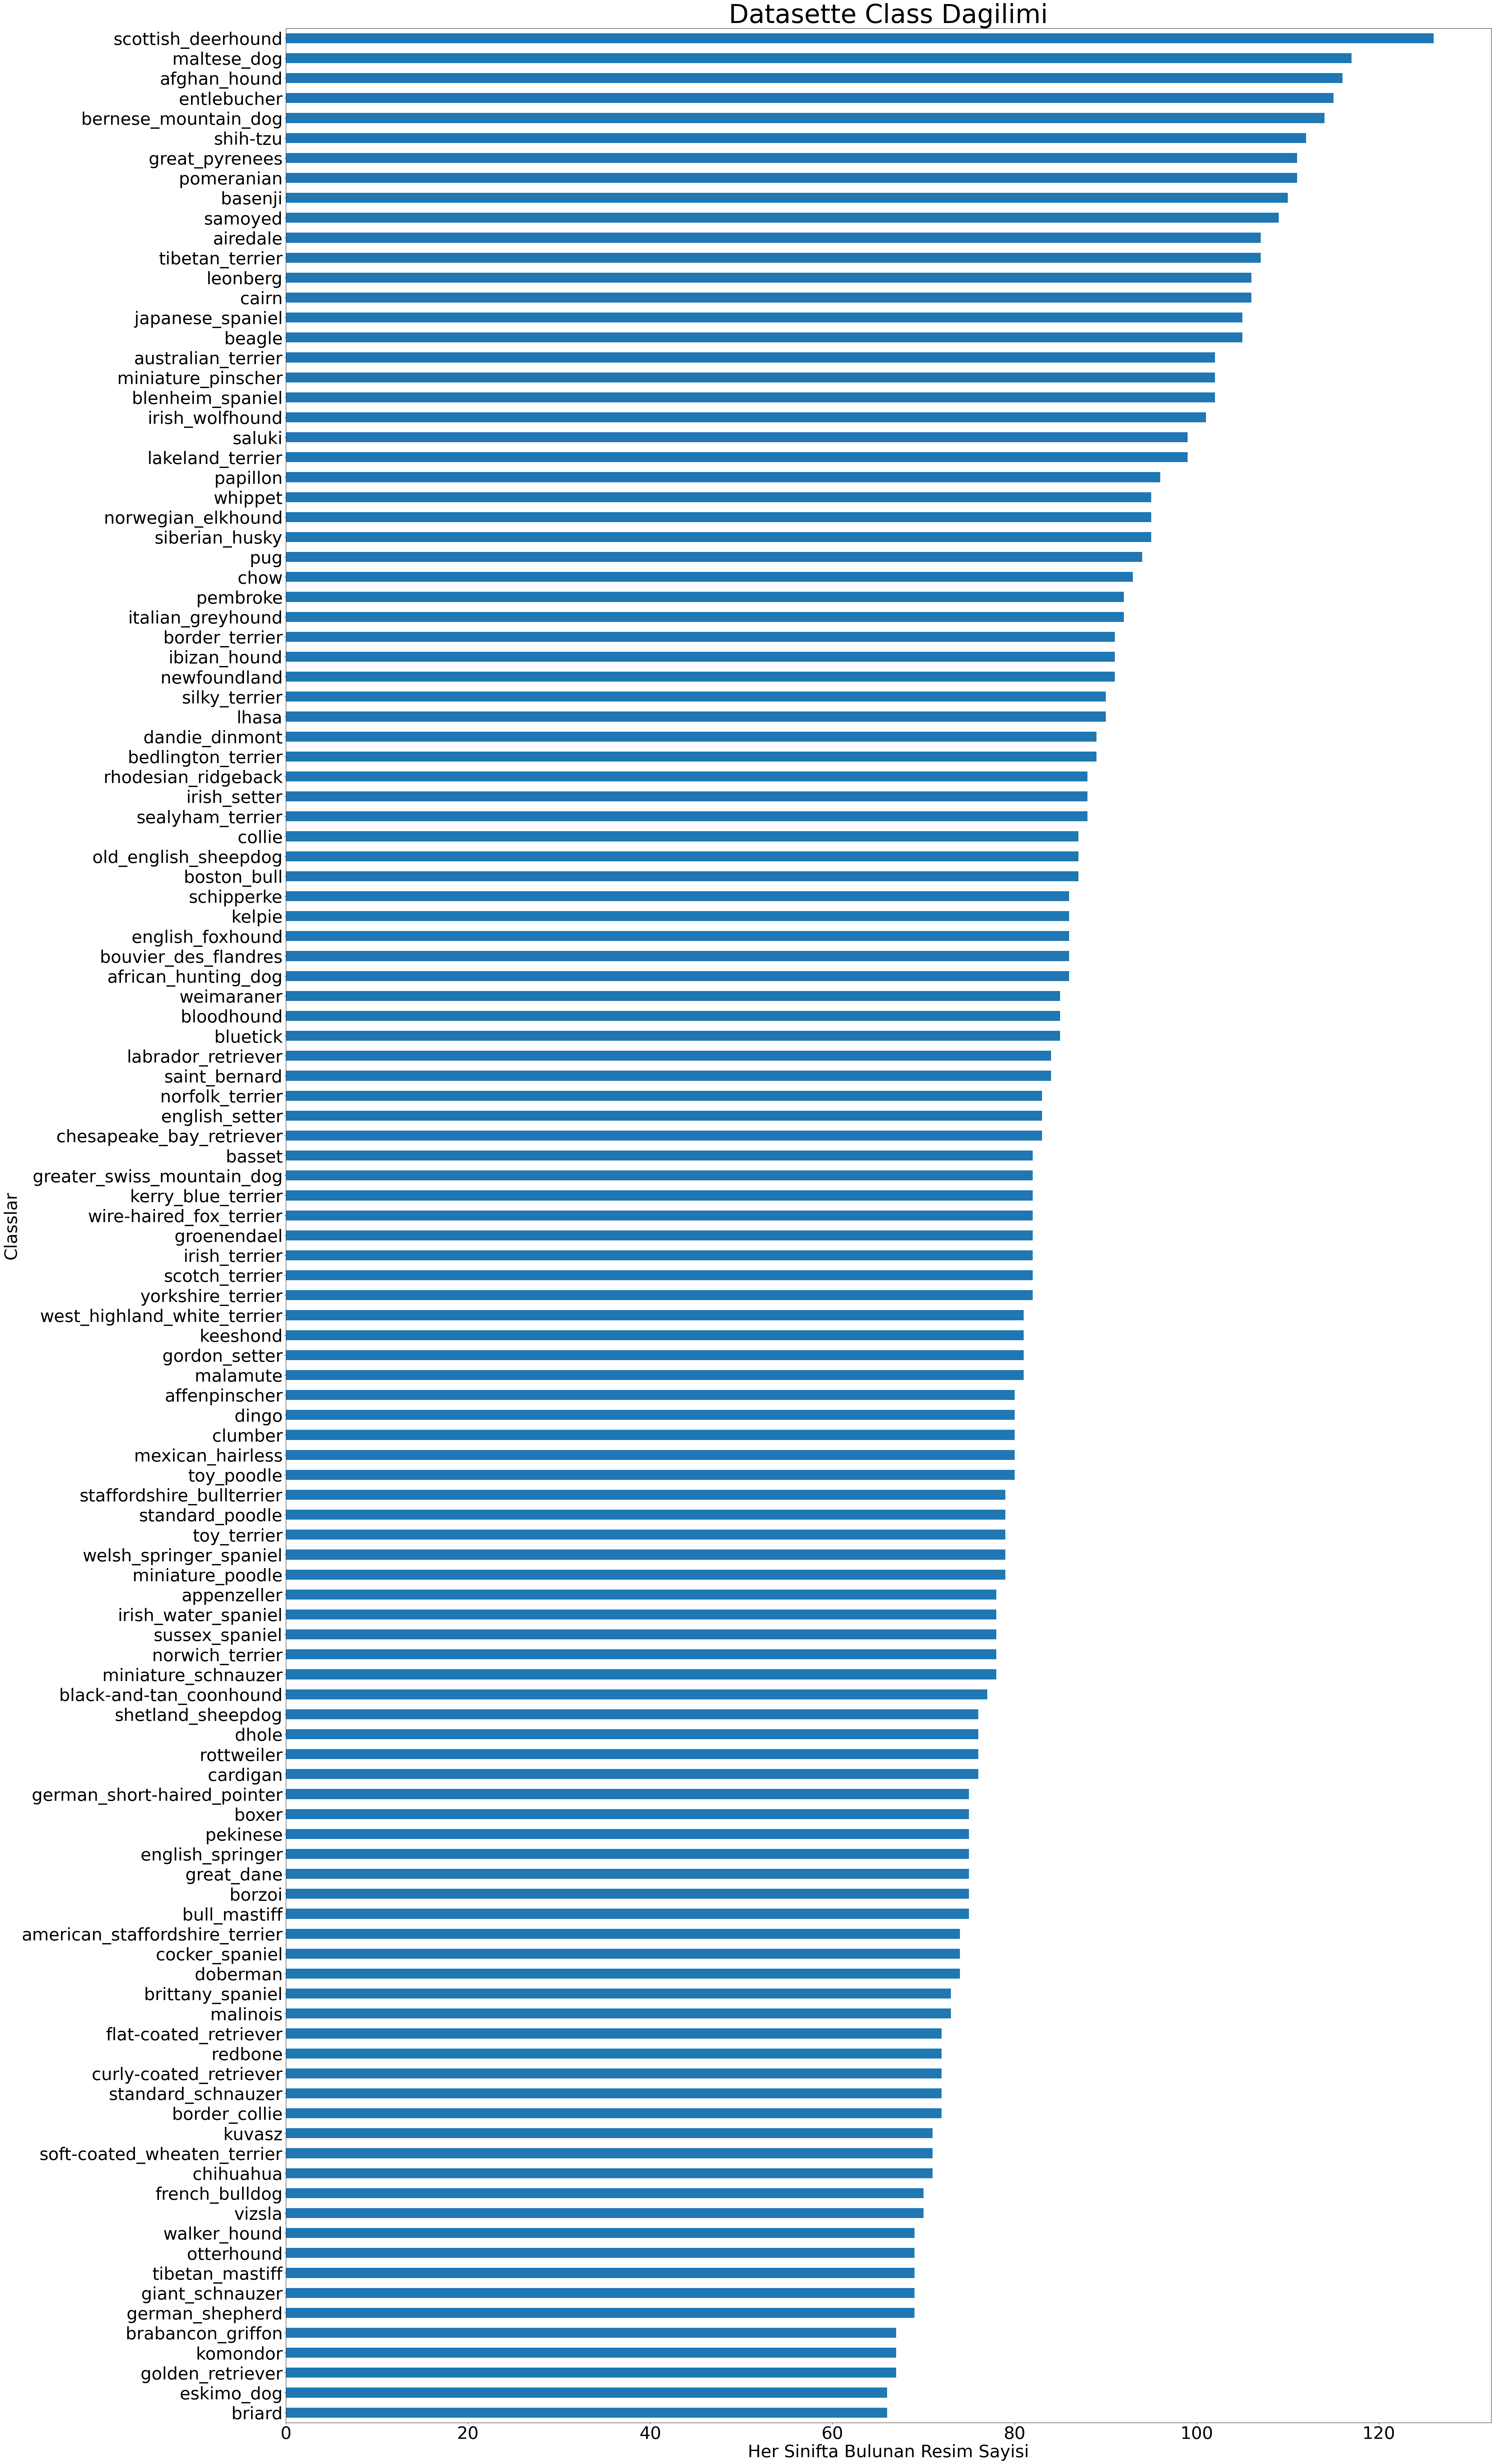

In [ ]:
#Classlarin datasette bulunma sayilarinin grafikte gosterilmesi
tablo_class = pd.value_counts(df_new['breed'], ascending=True).plot(kind='barh', fontsize="40", title="Datasette Class Dagilimi", figsize=(50,100))
tablo_class.set(xlabel = "Her Sinifta Bulunan Resim Sayisi", ylabel = "Classlar")
tablo_class.xaxis.label.set_size(40)
tablo_class.yaxis.label.set_size(40)
tablo_class.title.set_size(60)
plt.show()

In [ ]:
#Cok fazla resim olduğu icin sadece ilk 10 class ile islem yapildi.
first_10 = list(df.breed.value_counts()[0:10].index)
first_10

['scottish_deerhound',
 'maltese_dog',
 'afghan_hound',
 'entlebucher',
 'bernese_mountain_dog',
 'shih-tzu',
 'great_pyrenees',
 'pomeranian',
 'basenji',
 'samoyed']

In [ ]:
#Ilk 10 classin yeni data olarak alinmasi
df2 = df_new[df_new.breed.isin(first_10)]
df2.shape

(1141, 3)

In [ ]:
#Ilk 10 classin 224, 224 olarak renkli pixel dizisine donusturulmesi
img_pixel = np.array([img_to_array(load_img(img, target_size=(224, 224))) for img in df2['img_path'].values.tolist()])
img_pixel.shape

(1141, 224, 224, 3)

In [ ]:
img_label = df2.breed
img_label = pd.get_dummies(df2.breed)
img_label.head()

,afghan_hound,basenji,bernese_mountain_dog,entlebucher,great_pyrenees,maltese_dog,pomeranian,samoyed,scottish_deerhound,shih-tzu
8,0,1,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0
12,0,0,0,0,0,1,0,0,0,0
57,0,0,0,0,0,0,0,0,0,1
70,0,0,0,0,0,0,0,1,0,0


In [ ]:
X = img_pixel
y = img_label.values
print(X.shape)
print(y.shape)

(1141, 224, 224, 3)
(1141, 10)


In [ ]:
#Derin ogrenme icin train-test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(912, 224, 224, 3) (912, 10)
(229, 224, 224, 3) (229, 10)


In [ ]:
#data augmentation ve normalize the pixel values
train_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

In [ ]:
test_data = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_data.flow(X_train, y = y_train, batch_size=32)
testing_set = test_data.flow(X_test, y = y_test, batch_size=32)

In [ ]:
#model
model=Sequential()

model.add(ZeroPadding2D((1,1),input_shape=(224,224,3)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(ZeroPadding2D(padding=(1,1)))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10,activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_2 (ZeroPadd  (None, 226, 226, 3)       0         
 ing2D)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 zero_padding2d_3 (ZeroPadd  (None, 226, 226, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                      

In [ ]:
#modelin sonuclarinin alinmasi
results = model.fit(training_set, epochs=30, validation_data= testing_set)

Epoch 1/30
29/29 [==============================] - 15s 429ms/step - loss: 5.3281 - accuracy: 0.0954 - val_loss: 2.3031 - val_accuracy: 0.0655
Epoch 2/30
29/29 [==============================] - 12s 402ms/step - loss: 2.2969 - accuracy: 0.1283 - val_loss: 2.3077 - val_accuracy: 0.1310
Epoch 3/30
29/29 [==============================] - 11s 368ms/step - loss: 2.2740 - accuracy: 0.1524 - val_loss: 2.2786 - val_accuracy: 0.1616
Epoch 4/30
29/29 [==============================] - 11s 384ms/step - loss: 2.2251 - accuracy: 0.1721 - val_loss: 2.2089 - val_accuracy: 0.1659
Epoch 5/30
29/29 [==============================] - 14s 489ms/step - loss: 2.1375 - accuracy: 0.2303 - val_loss: 2.1784 - val_accuracy: 0.1878
Epoch 6/30
29/29 [==============================] - 12s 409ms/step - loss: 2.0812 - accuracy: 0.2281 - val_loss: 2.1382 - val_accuracy: 0.2358
Epoch 7/30
29/29 [==============================] - 13s 437ms/step - loss: 1.9889 - accuracy: 0.2840 - val_loss: 2.0737 - val_accuracy: 0.2052